In [1]:
import tensorflow as tf
import os, glob
import numpy as np
from astropy.constants import M_sun
from censai import PhysicalModel
from censai.data.cosmos import preprocess, decode
from censai.data import AugmentedTNGKappaGenerator
from censai.data.lenses_tng import encode_examples
from scipy.signal.windows import tukey
from datetime import datetime
import json
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from tqdm import tqdm

In [14]:
# import tensorflow as tf
# import numpy as np
# from censai.definitions import COSMO, DTYPE
# from astropy.constants import G, c, M_sun
# from astropy.io import fits
# from astropy import units as u
# from tensorflow_addons.image import rotate


# class AugmentedTNGKappaGenerator:
#     """
#     This class contains the logic for data augmentation of kappa maps based
#     on a rescaling factor, random shifts, crop and rotations.
#     """
#     def __init__(
#             self,
#             kappa_fits_files,               # fits files from rasterize scripts
#             z_lens: float = None,           # new z_lens if provided
#             z_source: float = None,
#             crop: int = 0,
#             max_shift: float = 1.,
#             rotate_by: str = "90",          # Either rotate by 90 degrees or 'uniform'
#             min_theta_e: float = 1,
#             max_theta_e: float = 5,
#             rescaling_size: int = 100,
#             rescaling_theta_bins: int = 10
#     ):
#         header = fits.open(kappa_fits_files[0])["PRIMARY"].header
#         self.kappa_files = kappa_fits_files
#         self.z_lens = z_lens if z_lens is not None else header["ZLENS"]
#         self.z_source = z_source if z_source is not None else header["ZSOURCE"]
#         self._crop = crop
#         self.max_shift_arcsec = max_shift
#         self.rescaling_size = rescaling_size
#         self.rescaling_theta_bins = rescaling_theta_bins
#         self.rotate_by = rotate_by

#         # ====== Extract information common to all fits ======
#         self.Dd = COSMO.angular_diameter_distance(self.z_lens)
#         self.Ds = COSMO.angular_diameter_distance(self.z_source)
#         self.Dds = COSMO.angular_diameter_distance_z1z2(self.z_lens, self.z_source)
#         self.sigma_crit = (c ** 2 * self.Ds / (4 * np.pi * G * self.Dd * self.Dds)).to(u.kg * u.Mpc ** (-2))
#         # Compute a rescaling factor given possibly new redshift pair
#         self.sigma_crit_factor = (header["SIGCRIT"] * (1e10 * M_sun * u.Mpc ** (-2)) / self.sigma_crit).decompose().value

#         pixels = fits.open(kappa_fits_files[0])["PRIMARY"].data.shape[0]  # pixels of the full cutout
#         self.physical_pixel_scale = header["FOV"] / pixels * u.Mpc
#         self.crop_pixels = pixels - 2 * crop  # pixels after crop
#         self.pixel_scale = header["CD1_1"]  # pixel scale in arc seconds
#         self.kappa_fov = self.pixel_scale * self.crop_pixels

#         self.min_theta_e = min_theta_e
#         self.max_theta_e = max_theta_e
#         # ====================================================
#         self.max_shift = min(int(max_shift / self.pixel_scale), self._crop - 1)
#         self.index = 0

#     def crop(self, kappa):
#         if len(kappa.shape) == 3:
#             return kappa[self._crop: -self._crop, self._crop: -self._crop, ...]
#         elif len(kappa.shape) == 4:
#             return kappa[..., self._crop: -self._crop, self._crop: -self._crop, :]

#     def crop_and_shift(self, kappa):
#         if len(kappa.shape) == 3:
#             shift = np.random.randint(low=-self.max_shift, high=self.max_shift, size=2)
#             return kappa[
#                    self._crop + shift[0]: -(self._crop - shift[0]),
#                    self._crop + shift[1]: -(self._crop - shift[1]), ...]
#         elif len(kappa.shape) == 4:
#             batch_size = kappa.shape[0]
#             kap = []
#             for j in range(batch_size):
#                 shift = np.random.randint(low=-self.max_shift, high=self.max_shift, size=2)
#                 kap.append(
#                     kappa[j,
#                     self._crop + shift[0]: -(self._crop - shift[0]),
#                     self._crop + shift[1]: -(self._crop - shift[1]), ...]
#                 )
#             kappa = tf.stack(kap, axis=0)
#             return kappa

#     def rotate(self, kappa):
#         if len(kappa.shape) == 3:
#             if self.rotate_by == "90":
#                 angle = np.random.randint(low=0, high=3, size=1)[0]
#                 return tf.image.rot90(kappa, k=angle)
#             elif self.rotate_by == "uniform":
#                 angle = np.random.uniform(low=-np.pi, high=np.pi, size=1)[0]
#                 return rotate(kappa, angle, interpolation="nearest", fill_mode="constant")
#         elif len(kappa.shape) == 4:
#             batch_size = kappa.shape[0]
#             if self.rotate_by == "90":
#                 rotated_kap = []
#                 for j in range(batch_size):
#                     angle = np.random.randint(low=0, high=3, size=1)[0]
#                     rotated_kap.append(
#                         tf.image.rot90(kappa[j], k=angle)
#                         )
#                 return tf.stack(rotated_kap, axis=0)
#             elif self.rotate_by == "uniform":
#                 angles = np.random.uniform(low=-np.pi, high=np.pi, size=batch_size)
#                 return rotate(kappa, angles, interpolation="nearest", fill_mode="constant")

#     def einstein_radius(self, kappa):
#         """
#         Einstein radius is computed with the mass inside the Einstein ring, which corresponds to
#         where kappa > 1.
#         Args:
#             kappa: A batch of kappa map of shape [batch_size, crop_pixels, crop_pixels, 1]

#         Returns: Einstein radius in arcsecond of shape [batch_size]
#         """
#         indicator_array = tf.cast(kappa > 1, tf.float32)
#         mass_inside_einstein_radius = np.sum(kappa * indicator_array, axis=(1, 2, 3)) * self.sigma_crit * self.physical_pixel_scale ** 2
#         return (np.sqrt(4 * G / c ** 2 * mass_inside_einstein_radius * self.Dds / self.Ds / self.Dd).decompose() * u.rad).to(u.arcsec).value

#     def compute_rescaling_probabilities(self, kappa, rescaling_array):
#         """
#         Args:
#             kappa: A single kappa map, of shape [crop_pixels, crop_pixels, 1]
#             rescaling_array: An array of rescaling factor for which we need to compute the Einstein radius

#         Returns: Probability of picking rescaling factor in rescaling array so that einstein radius has a
#             uniform distribution between minimum and maximum allowed value (defined at instantiation of class)
#         """
#         p = np.zeros_like(rescaling_array)
#         kappa = rescaling_array[..., np.newaxis, np.newaxis, np.newaxis] + kappa[np.newaxis, ...] # broadcast onto resaling array
#         theta_e = self.einstein_radius(kappa)
#         # compute theta distribution
#         select = (theta_e >= self.min_theta_e) & (theta_e <= self.max_theta_e)
#         if select.sum() == 0:  # no rescaling has landed in target range
#             return p
#         theta_hist, bin_edges = np.histogram(theta_e, bins=self.rescaling_theta_bins, range=[self.min_theta_e, self.max_theta_e], density=False)
#         # for each theta_e, find bin index of our histogram. We give the left edges of the bin (param right=False)
#         rescaling_bin = np.digitize(theta_e[select], bin_edges[:-1], right=False) - 1  # bin 0 is outside the range to the left by default
#         theta_hist[theta_hist == 0] = 1  # give empty bins a weight
#         p[select] = 1 / theta_hist[rescaling_bin]
#         p /= p.sum()  # normalize our new probability distribution
#         return p

#     def rescale(self, kappa):
#         """
#         Draw a rescaling factor from Uniform(min_theta_e, max_theta_e)
#         Args:
#             kappa: A batch of kappa map of shape [batch_size, crop_pixels, crop_pixels, 1]

#         Returns: kappa_rescaled, einstein_radius, rescaling_factors
#         """
#         batch_size = kappa.shape[0]
#         kappa_rescaled = []
#         rescaling_factors = []
#         new_einstein_radius = []
#         for j in range(batch_size):
#             kap = kappa[j]
#             if tf.reduce_max(kap) <= 1:  # make sure at least a few pixels will be dense enough for deflection
#                 kap += 1.05 - tf.reduce_max(kap)
#             theta_e = self.einstein_radius(kap[None, ...])[0]
#             # Rough estimate of allowed rescaling factors
#             rescaling_array = np.linspace(0, 0.2, self.rescaling_size) * self.sigma_crit_factor
#             # compute actual probabilities from sketched grid
#             rescaling_p = self.compute_rescaling_probabilities(kap, rescaling_array)
#             if rescaling_p.sum() == 0:  # all rescaling factors fell outside target range
#                 rescaling = 1.
#             else:
#                 rescaling = np.random.choice(rescaling_array, size=1, p=rescaling_p)[0]
# #             kappa_rescaled.append(rescaling[:, None, None, None] * kap[None, ...])
#             kappa_rescaled.append(rescaling + kap)
#             new_einstein_radius.append(self.einstein_radius(kappa_rescaled[-1][None, ...])[0])
#             rescaling_factors.append(rescaling)
#         kappa_rescaled = tf.stack(kappa_rescaled, axis=0)
#         return kappa_rescaled, new_einstein_radius, rescaling_factors

#     def draw_batch(self, batch_size, rescale: bool, shift: bool, rotate: bool, random_draw=True,
#                    return_einstein_radius_init=False):
#         if random_draw:
#             batch_indices = np.random.choice(list(range(len(self.kappa_files))), replace=False, size=batch_size)
#         else:
#             batch_indices = list(range(self.index, min(self.index + batch_size, len(self.kappa_files))))
#             if len(batch_indices) <= batch_size:
#                 self.index = 0  # reset counter
#             else:
#                 self.index += batch_size
#         kappa = []
#         kappa_ids = []
#         for kap_index in batch_indices:
#             kappa.append(fits.open(self.kappa_files[kap_index])["PRIMARY"].data[..., np.newaxis])  # add channel dim
#             kappa_ids.append(fits.open(self.kappa_files[kap_index])["PRIMARY"].header["SUBID"])
#         kappa = tf.stack(kappa, axis=0)  # stack on batch dimension
#         if rotate:
#             kappa = self.rotate(kappa)
#         if self._crop:
#             if shift:
#                 kappa = self.crop_and_shift(kappa)
#             else:
#                 kappa = self.crop(kappa)
#         if rescale:
#             theta_e_init = self.einstein_radius(kappa)
#             kappa, theta_e, rescaling_factors = self.rescale(kappa)
#             kappa = tf.cast(kappa, DTYPE)
#             if return_einstein_radius_init:
#                 return kappa, theta_e, rescaling_factors, kappa_ids, theta_e_init
#             else:
#                 return kappa, theta_e, rescaling_factors, kappa_ids
#         else:
#             theta_e = self.einstein_radius(kappa)
#             rescaling_factors = np.ones(kappa.shape[0])
#             kappa = tf.cast(kappa, DTYPE)
#             return kappa, theta_e, rescaling_factors, kappa_ids



In [129]:
kappa_dir = os.getenv("CENSAI_PATH") + "/data/hkappa158_TNG100_512"
image_fov = 17.8
min_theta_e = 2
max_theta_e = 6
z_lens = 0.44
z_source = 2.4
crop = 15
max_shift = 1
rotate_by = "90"
rescaling_size = 100
bins = 10
cosmos_dir = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_preprocessed_highSNR_verydiffuse"
buffer_size = 1000
batch = 10
tukey_alpha = 0
shuffle_cosmos = True
src_pixels = 128
psf_sigma = 0.1
lens_pixels = 128
noise_rms = 0.05
source_fov = 3


kappa_files = glob.glob(os.path.join(kappa_dir, "*.fits"))
if os.path.exists(os.path.join(kappa_dir, "good_kappa.txt")):  # filter out bad data (see validate_kappa_maps script)
    good_kappa = np.loadtxt(os.path.join(kappa_dir, "good_kappa.txt"))
    kappa_ids = [int(os.path.split(kap)[-1].split("_")[1]) for kap in kappa_files]
    keep_kappa = [kap_id in good_kappa for kap_id in kappa_ids]
    kappa_files = [kap_file for i, kap_file in enumerate(kappa_files) if keep_kappa[i]]

min_theta_e = 0.05 * image_fov if min_theta_e is None else min_theta_e
max_theta_e = 0.35 * image_fov if max_theta_e is None else max_theta_e
kappa_gen = AugmentedTNGKappaGenerator(
    kappa_fits_files=kappa_files,
    z_lens=z_lens,
    z_source=z_source,
    crop=crop,
    max_shift=max_shift,
    rotate_by=rotate_by,
    min_theta_e=min_theta_e,
    max_theta_e=max_theta_e,
    rescaling_size=rescaling_size,
    rescaling_theta_bins=bins
)
cosmos_files = glob.glob(os.path.join(cosmos_dir, "*.tfrecords"))
cosmos = tf.data.TFRecordDataset(cosmos_files)
n_galaxies = 0
for _ in cosmos:  # count the number of samples in the dataset
    n_galaxies += 1
cosmos = cosmos.map(decode).map(preprocess)
if shuffle_cosmos:
    cosmos = cosmos.shuffle(buffer_size=buffer_size)
cosmos = cosmos.batch(batch)

window = tukey(src_pixels, alpha=tukey_alpha)
window = np.outer(window, window)
phys = PhysicalModel(
    psf_sigma=psf_sigma,
    image_fov=image_fov,
    src_fov=source_fov,
    pixels=lens_pixels,
    kappa_pixels=kappa_gen.crop_pixels,
    src_pixels=src_pixels,
    kappa_fov=kappa_gen.kappa_fov,
    method="conv2d"
)

In [130]:
# batch_index = np.random.randint(0, n_galaxies//batch)
# for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
#     break
# galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

# batch_size = galaxies.shape[0]
# kappa, einstein_radius, rescaling_factors, kappa_ids, einstein_radius_init = kappa_gen.draw_batch(
#     batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=True)
# lens = []
# for b in range(batch_size):
#     lensed_images = phys.noisy_forward(tf.tile(galaxies[b][None, ...], [5, 1, 1, 1]), kappa, noise_rms=noise_rms)
#     lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
#     lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
#     im_flux = tf.reduce_sum(tf.cast(lensed_images>5*noise_rms, tf.float32), axis=(1, 2, 3)) * (image_fov/512)**2
#     src_flux = tf.reduce_sum(tf.cast(galaxies[b]>0, tf.float32)) * (source_fov/128)**2
#     magnification = im_flux / src_flux
#     print(magnification)
#     fig, axs = plt.subplots(10, 3, figsize=(15, 50))
#     for i in range(0, 10):
#         axs[i, 0].imshow(kappa[b][i][..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
#         axs[i, 1].imshow(galaxies[b][..., 0], cmap="bone")
#         axs[i, 2].imshow(lensed_images[i][..., 0], cmap="bone", vmin=0, vmax=1)
#         axs[i, 2].set_title(f"{magnification[i]:.2f}")
#         for j in range(3):
#             axs[i, j].axis("off")        
# #     plt.subplots_adjust(wspace=0, hspace=0)
#     break

In [131]:
batch_index = np.random.randint(0, n_galaxies//batch)
for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
    break
galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

batch_size = galaxies.shape[0]
kappa, einstein_radius, rescaling_factors, kappa_ids = kappa_gen.draw_batch(
    batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=False)

lensed_images = phys.noisy_forward(galaxies, kappa/2, noise_rms=noise_rms)
lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
im_area = tf.reduce_sum(tf.cast(lensed_images>0.5, tf.float32), axis=(1, 2, 3)) * (image_fov/lensed_images.shape[1])**2
src_area = tf.reduce_sum(tf.cast(galaxies>0.5, tf.float32), axis=(1, 2, 3)) * (source_fov/galaxies.shape[1])**2
magnification = im_area / src_area

In [132]:
im_area

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.5801514 , 0.17404541, 0.15470703, 1.0829492 , 0.13536865,
       0.19338378, 0.05801514, 0.19338378, 0.09669189, 1.0055957 ],
      dtype=float32)>

In [133]:
src_area

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.05328369, 0.05987549, 0.04943848, 0.10876465, 0.02087402,
       0.0401001 , 0.04779053, 0.02197266, 0.02362061, 0.04559326],
      dtype=float32)>

In [134]:
# batch_index = np.random.randint(0, n_galaxies//batch)
# for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
#     break
# galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

# batch_size = galaxies.shape[0]
# kappa, einstein_radius, rescaling_factors, kappa_ids, einstein_radius_init = kappa_gen.draw_batch(
#     batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=True)

# lensed_images = []
# magnification = []
# for i in tqdm(range(batch)):
#     im, jacobian = phys.lens_source_and_compute_jacobian(galaxies[i][None, ...], kappa[i][None])
# #     lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
# #     lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
#     lensed_images.append(im)
#     magnification.append(tf.linalg.det(jacobian)**(-1))

In [135]:
# mmean = [m.numpy().squeeze()[lensed_images[i].numpy().squeeze() > 0].mean()  for i, m in enumerate(magnification)]

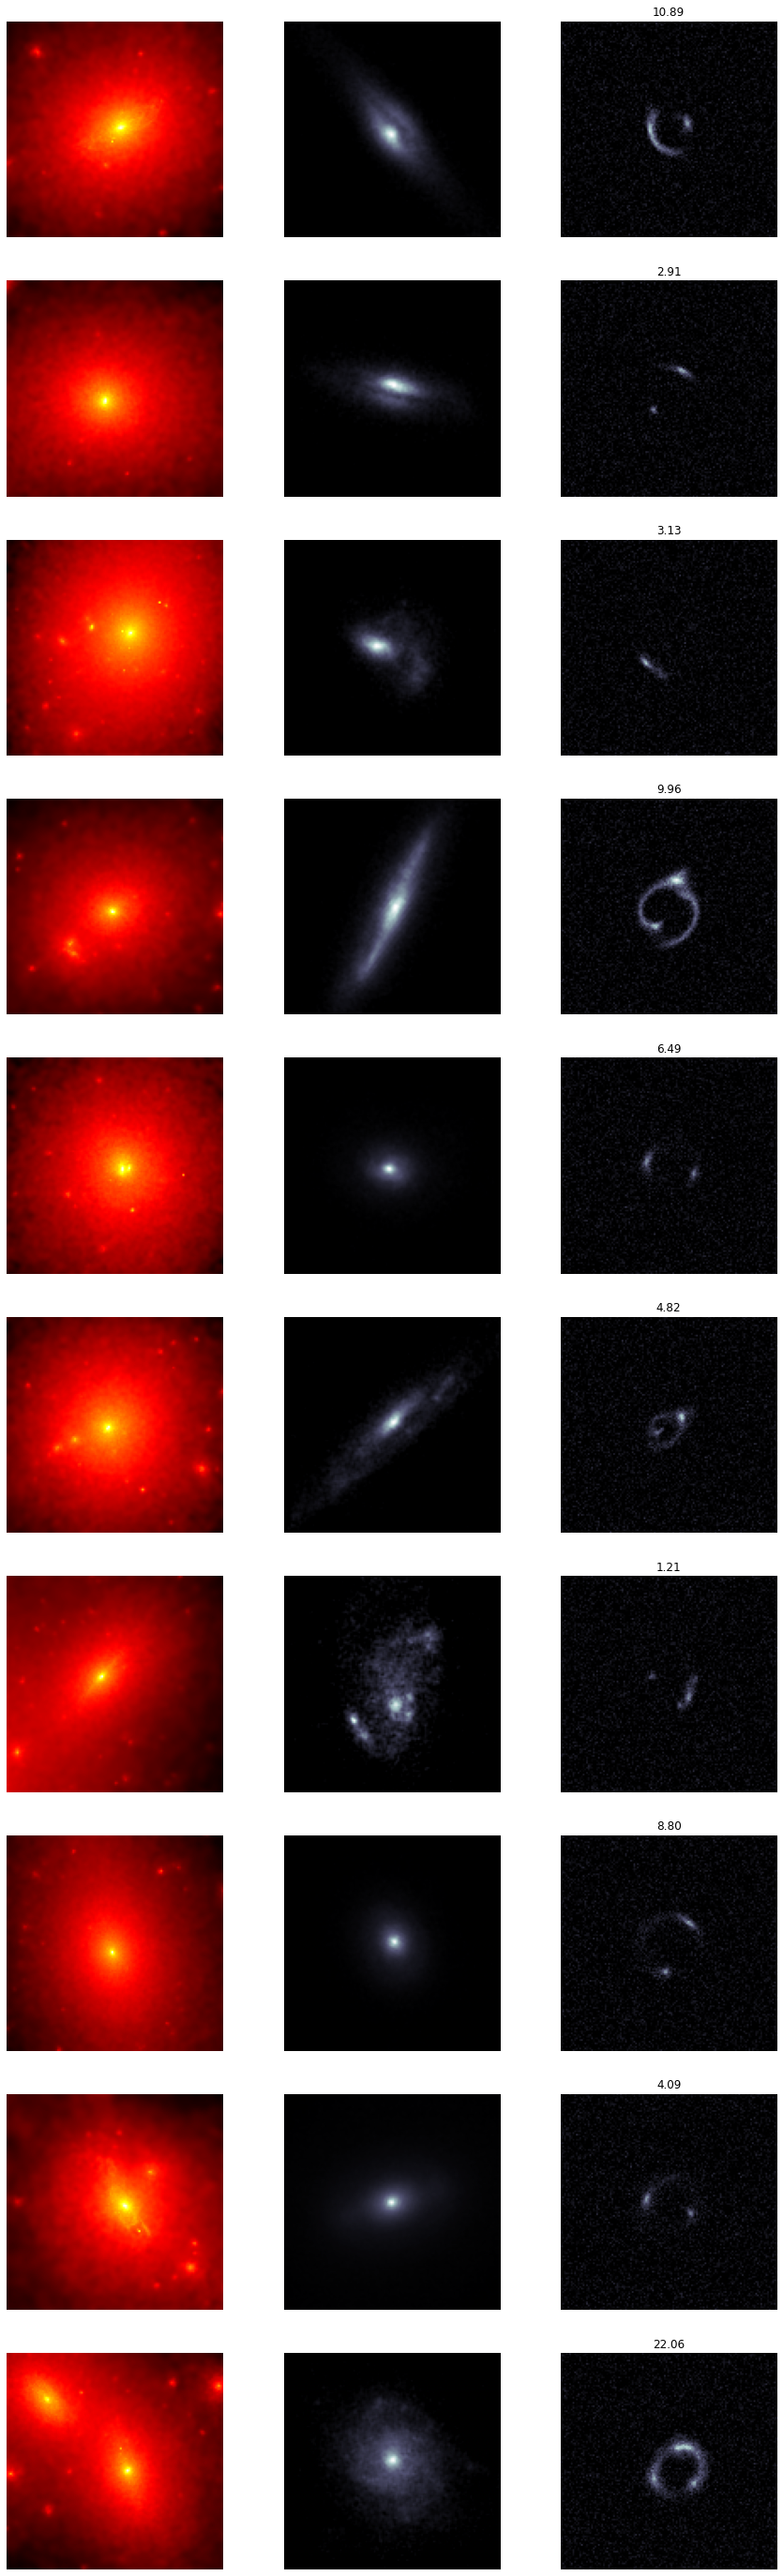

In [136]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
fig, axs = plt.subplots(10, 3, figsize=(15, 50))
for i in range(0, 10):
    axs[i, 0].imshow(kappa[i][..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
    axs[i, 1].imshow(galaxies[i][..., 0], cmap="bone")
    axs[i, 2].imshow(lensed_images[i][ ..., 0], cmap="bone", vmin=0, vmax=1)
    axs[i, 2].set_title(f"{magnification[i]:.2f}")
#     axs[i, 2].set_title(f"{lensed_images[i].numpy().sum():.2f}")
#     axs[i, 1].set_title(f"{galaxies[i].numpy().sum():.2f}")


#     im = axs[i, 3].imshow(magnification[i][0, ...], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100))
#     divider = make_axes_locatable(axs[i, 3])
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     axs[i, 3].axis("off")
    for j in range(3):
        axs[i, j].axis("off")        
# plt.subplots_adjust(wspace=0, hspace=0)

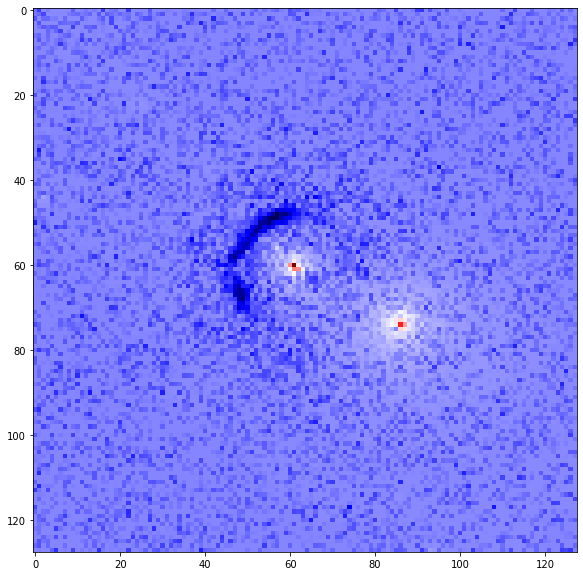

In [120]:
i = 5
plt.figure(figsize=(10, 10))
plt.imshow(kappa[i][..., 0] - 30*lensed_images[i][..., 0], cmap="seismic")